# Multi-Agent Reinforcement Learning with TF-Agents

In this notebook we're going to be implementing reinforcement learning (RL) agents to play games against one another. Before reading this it is advised to be familiar with the [TF-Agents](https://github.com/tensorflow/agents) and Deep Q-Learning; [this tutorial](https://github.com/tensorflow/agents/blob/master/docs/tutorials/1_dqn_tutorial.ipynb) will bring you up to speed.

## Introduction

TF-Agents is a framework for designing and experimenting with RL algorithms. It provides a collection of useful abstractions such as agents, replay buffers, and drivers. However, the code is quite rigidly tied to the single-agent view, which is explained by the *extrinsically motivated* agent in the diagram below.

In this view, the environment provides observations and rewards to the agent. Under the assumption that there is only one agent this makes sense, however, when we have many agents in the same space we would like to have agent-specific observations and rewards. In order to rectify this we first need to think of agents as *intrinsically motivated*, which is to say that their rewards are a function of their observations and internal state. Secondly, the agent is only *partially observing* the environment, and the window into the environment is a function of the agent's total state. This total state can include "physical" properties of the agent such as position, but it also includes internal state. For example, an agent could have an internal `is_sleeping` parameter that multiplies their observations by zero to simulate a lack of light.

## Implementing the IMAgent

In order to implement this with TF-Agents we are going to define an `IMAgent` (Intrinsically Motivated Agent) class by overriding the `DqnAgent` class. In the standard TF-Agents DQN pipeline the agent is trained by alternating between data collection and training updates to the Q-Network. Data collection is done with a special `collect_policy` which behaves differently to the main policy for the sake of managing the exploitation-exploration trade-off. Usually, the environment and the agent are separated. The environment generates a `TimeStep` containing the observation and reward information which is then passed to `policy.action`. This produces a `PolicyStep` that contains an action to step the environment. 

<img src="./im_rl_agent.png" width="600px" display="block" margin-left="auto" margin-right="auto"/>

This provides us with two approaches to our problem. We could make the enviroment aware of which agent it is producing the `TimeStep` for, or we could have each agent ingest an agent-independent time step that is then augmented internally. Here we argue that the latter is a more natural decomposition as it keeps the agent-specific code with the agent class. 

In [214]:
from functools import partial
from IPython.display import clear_output
from itertools import cycle
from pathlib import Path
import random
from time import time
from typing import Tuple, List, Callable

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()

import tensorflow as tf
from tf_agents.agents import DqnAgent
from tf_agents.agents.tf_agent import LossInfo
from tf_agents.environments.py_environment import PyEnvironment
from tf_agents.environments.tf_py_environment import TFPyEnvironment
from tf_agents.networks.q_rnn_network import QRnnNetwork
from tf_agents.replay_buffers.tf_uniform_replay_buffer import TFUniformReplayBuffer
from tf_agents.specs import TensorSpec
from tf_agents.trajectories import trajectory
from tf_agents.trajectories.time_step import TimeStep
from tf_agents.trajectories.trajectory import Trajectory
from tf_agents.utils import common

print('Physical Devices:\n', tf.config.list_physical_devices(), '\n\n')

OUTPUTS_DIR = f'./outputs/{int(10000000 * time())}'
print('Output Directory:', OUTPUTS_DIR)

Physical Devices:
 [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')] 


Output Directory: ./outputs/15918169468946548


In [599]:
class IMAgent(DqnAgent):

    def __init__(self,
                 env: TFPyEnvironment,
                 observation_spec: TensorSpec = None,
                 action_spec: TensorSpec = None,
                 reward_fn: Callable = lambda time_step: time_step.reward,
                 action_fn: Callable = lambda action: action,
                 name: str='IMAgent',
                 q_network=None,
                 # training params
                 replay_buffer_max_length: int = 1000,
                 learning_rate: float = 1e-5,
                 training_batch_size: int = 8,
                 training_parallel_calls: int = 3,
                 training_prefetch_buffer_size: int = 3,
                 training_num_steps: int = 2,
                 **dqn_kwargs):

        self._env = env
        self._reward_fn = reward_fn
        self._name = name
        self._observation_spec = observation_spec or self._env.observation_spec()
        self._action_spec = action_spec or self._env.action_spec()
        self._action_fn = action_fn

        q_network = q_network or self._build_q_net()

        env_ts_spec = self._env.time_step_spec()
        time_step_spec = TimeStep(
            step_type=env_ts_spec.step_type,
            reward=env_ts_spec.reward,
            discount=env_ts_spec.discount,
            observation=q_network.input_tensor_spec
        )

        optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        super().__init__(time_step_spec,
                         self._action_spec,
                         q_network,
                         optimizer,
                         name=name,
                         **dqn_kwargs)

        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size)
        self._rewards = []

        self._replay_buffer = TFUniformReplayBuffer(
            data_spec=self.collect_data_spec,
            batch_size=self._env.batch_size,
            max_length=replay_buffer_max_length)
        
        self._training_batch_size = training_batch_size
        self._training_parallel_calls = training_parallel_calls
        self._training_prefetch_buffer_size = training_prefetch_buffer_size
        self._training_num_steps = training_num_steps
        self.train = common.function(self.train)

    def _build_q_net(self):
        qrnn = QRnnNetwork(input_tensor_spec=self._observation_spec,
                           action_spec=self._action_spec,
                           name=f'{self._name}QRNN')

        qrnn.create_variables()
        qrnn.summary()

        return qrnn

    def reset(self):
        self._policy_state = self.policy.get_initial_state(
            batch_size=self._env.batch_size
        )
        self._rewards = []
        
    def episode_return(self) -> float:
        return np.sum(self._rewards)
        
    def _observation_fn(self, observation: tf.Tensor) -> tf.Tensor:
        """
            Takes a tensor with specification self._env.observation_spec
            and extracts a tensor with specification self._observation_spec.
            
            For example, consider an agent within an NxN maze environment. 
            The env could expose the entire NxN integer matrix as an observation
            but we would prefer the agent to only see a 3x3 window around their
            current location. To do this we can override this method.
            
            This allows us to have different agents acting in the same environment
            with different observations.
        """
        return observation

    def _augment_time_step(self, time_step: TimeStep) -> TimeStep:

        reward = self._reward_fn(time_step)
        reward = tf.convert_to_tensor(reward, dtype=tf.float32)
        if reward.shape != time_step.reward.shape:
            reward = tf.reshape(reward, time_step.reward.shape)
            
        observation = self._observation_fn(time_step.observation)

        return TimeStep(
            step_type=time_step.step_type,
            reward=reward,
            discount=time_step.discount,
            observation=observation
        )

    def _current_time_step(self) -> TimeStep:
        time_step = self._env.current_time_step()
        time_step = self._augment_time_step(time_step)
        return time_step

    def _step_environment(self, action) -> TimeStep:
        action = self._action_fn(action)
        time_step = self._env.step(action)
        time_step = self._augment_time_step(time_step)
        return time_step

    def act(self, collect=False) -> Trajectory:
        time_step = self._current_time_step()

        if collect:
            policy_step = self.collect_policy.action(
                time_step, policy_state=self._policy_state)
        else:
            policy_step = self.policy.action(
                time_step, policy_state=self._policy_state)

        self._policy_state = policy_step.state
        next_time_step = self._step_environment(policy_step.action)
        traj = trajectory.from_transition(time_step, policy_step, next_time_step)

        self._rewards.append(next_time_step.reward)
        
        if collect:
            self._replay_buffer.add_batch(traj)

        return traj

    def train_iteration(self) -> LossInfo:
        experience, info = self._replay_buffer.get_next(
            sample_batch_size=self._training_batch_size,
            num_steps=self._training_num_steps
        )
        return self.train(experience)

## Tic-Tac-Toe Example

<img src="https://upload.wikimedia.org/wikipedia/commons/thumb/3/32/Tic_tac_toe.svg/1200px-Tic_tac_toe.svg.png" width="300px"/>

In order to test this we can utlise the [already-implemented Tic-Tac-Toe environment](https://github.com/tensorflow/agents/blob/master/tf_agents/environments/examples/tic_tac_toe_environment.py) in TF-Agents (At the time of writing this script has not been added to the pip distribution so I have manually copied it across). The environment represents the problem on a 3x3 matrix where a 0 represents an empty slot, a 1 represents a play by player 1, and a 2 represents a play by player 2. However, as TF-Agents is not focused on the multi-agent case, their implementation has the second player act randomly. To change this we will override the step function.

The only additional change that we need to make is to the action specification, where we need to provide the value that is being placed (i.e. which player is making the move).

In [600]:
from tic_tac_toe_environment import TicTacToeEnvironment
from tf_agents.specs import BoundedArraySpec
from tf_agents.trajectories.time_step import StepType

REWARD_ILLEGAL_MOVE = np.asarray(-2, dtype=np.float32)

class TicTacToeMultiAgentEnv(TicTacToeEnvironment):
    
    def action_spec(self):
        position_spec = BoundedArraySpec((1,), np.int32, minimum=0, maximum=8)
        value_spec = BoundedArraySpec((1,), np.int32, minimum=1, maximum=2)
        return {
            'position': position_spec,
            'value': value_spec
        }
    
    def _step(self, action: np.ndarray):
        if self._current_time_step.is_last():
            return self._reset()

        index_flat = np.array(range(9)) == action['position']
        index = index_flat.reshape(self._states.shape) == True
        if self._states[index] != 0:
            return TimeStep(StepType.LAST, 
                            REWARD_ILLEGAL_MOVE,
                            self._discount, 
                            self._states)

        self._states[index] = action['value']

        is_final, reward = self._check_states(self._states)
        
        if np.all(self._states == 0):
            step_type = StepType.FIRST
        elif is_final:
            step_type = StepType.LAST
        else:
            step_type = StepType.MID

        return TimeStep(step_type, reward, self._discount, self._states)

In [601]:
def print_tic_tac_toe(state):
    table_str = '''
    {} | {} | {}
    - + - + -
    {} | {} | {}
    - + - + -
    {} | {} | {}
    '''.format(*tuple(state.flatten()))
    table_str = table_str.replace('0', ' ')
    table_str = table_str.replace('1', 'X')
    table_str = table_str.replace('2', 'O')
    print(table_str)

In [602]:
tic_tac_toe_env = TicTacToeMultiAgentEnv()

ts = tic_tac_toe_env.reset()
print('Reward:', ts.reward, 'Board:')
print_tic_tac_toe(ts.observation)

random.seed(1)
player = 1
while not ts.is_last():
    action = {
        'position': np.asarray(random.randint(0, 8)),
        'value': player
    }
    ts = tic_tac_toe_env.step(action)
    print('Player:', player, 'Action:', action['position'],
          'Reward:', ts.reward, 'Board:')
    print_tic_tac_toe(ts.observation)
    player = 1 + player % 2

Reward: 0.0 Board:

      |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 1 Action: 2 Reward: 0.0 Board:

      |   | X
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 2 Action: 1 Reward: 0.0 Board:

      | O | X
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: 1 Action: 4 Reward: 0.0 Board:

      | O | X
    - + - + -
      | X |  
    - + - + -
      |   |  
    
Player: 2 Action: 1 Reward: -2.0 Board:

      | O | X
    - + - + -
      | X |  
    - + - + -
      |   |  
    


In [603]:
def ttt_action_fn(player, action):
    return {'position': action, 'value': player}

tf_ttt_env = TFPyEnvironment(tic_tac_toe_env)

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 1),
    name='Player1'
)

def p2_reward_fn(ts: TimeStep) -> float:
    if ts.reward == -1.0:
        return 1.0
    if ts.reward == 1.0:
        return -1.0
    return ts.reward

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2'
)

Model: "Player1QRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  3790      
_________________________________________________________________
dynamic_unroll_164 (DynamicU multiple                  12960     
_________________________________________________________________
Player1QRNN/dense (Dense)    multiple                  3075      
_________________________________________________________________
Player1QRNN/dense (Dense)    multiple                  3040      
_________________________________________________________________
num_action_project/dense (De multiple                  369       
Total params: 23,234
Trainable params: 23,234
Non-trainable params: 0
_________________________________________________________________
Model: "Player2QRNN"
_________________________________________________________________
Layer (type)                 O

In [604]:
ts = tf_ttt_env.reset()

# arbitrary starting point to add variety
random.seed(1)
start_player_id = random.randint(1, 2)
tf_ttt_env.step({'position': tf.convert_to_tensor([random.randint(0, 8)]), 
                 'value': start_player_id})
ts = tf_ttt_env.current_time_step()
print('Random start board:')
print_tic_tac_toe(ts.observation.numpy())

if start_player_id == 2:
    players = cycle([player_1, player_2])
else:
    players = cycle([player_2, player_1])
    
while not ts.is_last():
    player = next(players)
    player.act()
    ts = tf_ttt_env.current_time_step()
    print(f'Player: {player.name}, Reward: {ts.reward[0]}')
    print_tic_tac_toe(ts.observation.numpy())

Random start board:

      | X |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    
Player: Player2, Reward: 0.0

      | X |  
    - + - + -
    O |   |  
    - + - + -
      |   |  
    
Player: Player1, Reward: 0.0

      | X |  
    - + - + -
    O |   | X
    - + - + -
      |   |  
    
Player: Player2, Reward: -2.0

      | X |  
    - + - + -
    O |   | X
    - + - + -
      |   |  
    


In [605]:
ts = tf_ttt_env.reset()

tf_ttt_env.step({'position': tf.convert_to_tensor([0]), 
                 'value': 2})

tf_ttt_env.step({'position': tf.convert_to_tensor([4]), 
                 'value': 2})

tf_ttt_env.step({'position': tf.convert_to_tensor([8]), 
                 'value': 2})

ts = tf_ttt_env.current_time_step()
print(ts)
print_tic_tac_toe(ts.observation.numpy())

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[2, 0, 0],
        [0, 2, 0],
        [0, 0, 2]]])>)

    O |   |  
    - + - + -
      | O |  
    - + - + -
      |   | O
    


In [606]:
player_1._augment_time_step(ts)

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[2, 0, 0],
        [0, 2, 0],
        [0, 0, 2]]])>)

In [607]:
player_2._augment_time_step(ts)

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[2, 0, 0],
        [0, 2, 0],
        [0, 0, 2]]])>)

In [608]:
ts = tf_ttt_env.reset()

tf_ttt_env.step({'position': tf.convert_to_tensor([0]), 
                 'value': 1})

tf_ttt_env.step({'position': tf.convert_to_tensor([4]), 
                 'value': 1})

tf_ttt_env.step({'position': tf.convert_to_tensor([8]), 
                 'value': 1})

ts = tf_ttt_env.current_time_step()
print(ts)
print_tic_tac_toe(ts.observation.numpy())

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]])>)

    X |   |  
    - + - + -
      | X |  
    - + - + -
      |   | X
    


In [609]:
player_1._augment_time_step(ts)

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]])>)

In [610]:
player_2._augment_time_step(ts)

TimeStep(step_type=<tf.Tensor: shape=(1,), dtype=int32, numpy=array([2])>, reward=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([-1.], dtype=float32)>, discount=<tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>, observation=<tf.Tensor: shape=(1, 3, 3), dtype=int32, numpy=
array([[[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]])>)

In [611]:
def training_episode(tf_ttt_env, player_1, player_2):
    ts = tf_ttt_env.reset()
    player_1.reset()
    player_2.reset()
    if bool(random.randint(0, 1)):
        players = cycle([player_1, player_2])
    else:
        players = cycle([player_2, player_1])
    while not ts.is_last():
        player = next(players)
        player.act(collect=True)
        ts = tf_ttt_env.current_time_step()

In [612]:
training_episode(tf_ttt_env, player_1, player_2)

In [613]:
player_1._replay_buffer.num_frames()

<tf.Tensor: shape=(), dtype=int64, numpy=3>

In [614]:
traj, info = player_1._replay_buffer.get_next(num_steps=2, sample_batch_size=2)
print(traj)
print()
print(info)

Trajectory(step_type=<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 1],
       [1, 1]])>, observation=<tf.Tensor: shape=(2, 2, 3, 3), dtype=int32, numpy=
array([[[[1, 2, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 2, 0],
         [2, 0, 0],
         [0, 1, 0]]],


       [[[1, 2, 0],
         [0, 0, 0],
         [0, 0, 0]],

        [[1, 2, 0],
         [2, 0, 0],
         [0, 1, 0]]]])>, action=<tf.Tensor: shape=(2, 2, 1), dtype=int32, numpy=
array([[[7],
        [7]],

       [[7],
        [7]]])>, policy_info=(), next_step_type=<tf.Tensor: shape=(2, 2), dtype=int32, numpy=
array([[1, 2],
       [1, 2]])>, reward=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[ 0., -2.],
       [ 0., -2.]], dtype=float32)>, discount=<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>)

BufferInfo(ids=<tf.Tensor: shape=(2, 2), dtype=int64, numpy=
array([[1, 2],
       [1, 2]], dtype=int64)>, probabilities=<tf.Tensor: shape

In [615]:
player_1.episode_return(), player_2.episode_return()

(-2.0, 0.0)

In [670]:
def collect_training_data():
    for game in range(episodes_per_iteration):
        training_episode(tf_ttt_env, player_1, player_2)

        p1_return = player_1.episode_return()
        p2_return =  player_2.episode_return()

        if REWARD_ILLEGAL_MOVE in [p1_return, p2_return]:
            outcome = 'illegal'
        elif p1_return == TicTacToeEnvironment.REWARD_WIN:
            outcome = 'p1_win'
        elif p2_return == TicTacToeEnvironment.REWARD_WIN:
            outcome = 'p2_win'
        else:
            outcome = 'draw'
        
        games.append({
            'iteration': iteration,
            'game': game,
            'p1_return': p1_return,
            'p2_return': p2_return,
            'outcome': outcome,
            'final_step': tf_ttt_env.current_time_step()
        })

def train():
    for _ in range(train_steps_per_iteration):
        p1_train_info = player_1.train_iteration()
        p2_train_info = player_2.train_iteration()
    
        loss_infos.append({
            'iteration': iteration,
            'p1_loss': p1_train_info.loss.numpy(),
            'p2_loss': p2_train_info.loss.numpy()
        })

def plot_history():
    
    games_data = pd.DataFrame.from_records(games)
    loss_data = pd.DataFrame.from_records(loss_infos)
    loss_data['Player 1'] = np.log(loss_data.p1_loss)
    loss_data['Player 2'] = np.log(loss_data.p2_loss)
    
    fig, axs = plt.subplots(2, 2, figsize=(15, 12))
    
    loss_melted = pd.melt(loss_data, 
                          id_vars=['iteration'], 
                          value_vars=['Player 1', 'Player 2'])
    smoothing = iteration // 50
    loss_melted.iteration = smoothing * (loss_melted.iteration // smoothing)

    sns.lineplot(ax=axs[0][0], 
                 x='iteration', hue='variable', 
                 y='value', data=loss_melted)
    axs[0][0].set_title('Loss History')
    axs[0][0].set_ylabel('log-loss')
    
    returns_melted = pd.melt(games_data, 
                             id_vars=['iteration'], 
                             value_vars=['p1_return', 'p2_return'])
    returns_melted.iteration = smoothing * (returns_melted.iteration // smoothing)
    sns.lineplot(ax=axs[0][1], 
                 x='iteration', hue='variable', 
                 y='value', data=returns_melted)
    axs[0][1].set_title('Return History')
    axs[0][1].set_ylabel('return')

    games_data['p1_win'] = games_data.outcome == 'p1_win'
    games_data['p2_win'] = games_data.outcome == 'p2_win'
    games_data['illegal'] = games_data.outcome == 'illegal'
    grouped_games_data = games_data.groupby('iteration')
    cols = ['game', 'p1_win', 'p2_win', 'illegal']
    grouped_games_data = grouped_games_data[cols]
    game_totals =  grouped_games_data.max()['game'] + 1
    summed_games_data = grouped_games_data.sum()
    summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
    summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
    summed_games_data['illegal_rate'] = summed_games_data.illegal / game_totals
    summed_games_data['iteration'] = smoothing * (summed_games_data.index // smoothing)
    
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p1_win',
                 data=summed_games_data,
                 label='Player 1 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='p2_win',
                 data=summed_games_data,
                 label='Player 2 Win Rate')
    sns.lineplot(ax=axs[1][0],
                 x='iteration',
                 y='illegal',
                 data=summed_games_data,
                 label='Illegal Ending Ratio')
    axs[1][0].set_title('Outcomes History')
    axs[1][0].set_ylabel('Percentage')
    
    plt.show()

In [668]:
num_iterations = 10000
initial_collect_episodes = 100
episodes_per_iteration = 25
train_steps_per_iteration = 1
training_batch_size = 512
training_num_steps = 2
replay_buffer_size = 50000
learning_rate = 1e-3
plot_interval = 50

In [618]:
iteration = 1
games = []
loss_infos = []

player_1 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 1),
    name='Player1',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

player_2 = IMAgent(
    tf_ttt_env,
    action_spec = tf_ttt_env.action_spec()['position'],
    action_fn = partial(ttt_action_fn, 2),
    reward_fn = p2_reward_fn,
    name='Player2',
    learning_rate = learning_rate,
    training_batch_size = training_batch_size,
    training_num_steps = training_num_steps,
    replay_buffer_max_length = replay_buffer_size,
    td_errors_loss_fn=common.element_wise_squared_loss
)

print('Collecting Initial Training Sample...')
for _ in range(initial_collect_episodes):
    training_episode(tf_ttt_env, player_1, player_2)
print('Samples collected')

Model: "Player1QRNN"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
EncodingNetwork (EncodingNet multiple                  3790      
_________________________________________________________________
dynamic_unroll_168 (DynamicU multiple                  12960     
_________________________________________________________________
Player1QRNN/dense (Dense)    multiple                  3075      
_________________________________________________________________
Player1QRNN/dense (Dense)    multiple                  3040      
_________________________________________________________________
num_action_project/dense (De multiple                  369       
Total params: 23,234
Trainable params: 23,234
Non-trainable params: 0
_________________________________________________________________
Model: "Player2QRNN"
_________________________________________________________________
Layer (type)                 O

In [619]:
import logging
logging.basicConfig(format='%(asctime)s %(levelname)s: %(message)s', 
                    level=logging.CRITICAL, datefmt='%I:%M:%S')
logger = logging.getLogger('training_info')

# comment out the line below to enable logging
logger.setLevel(logging.CRITICAL)

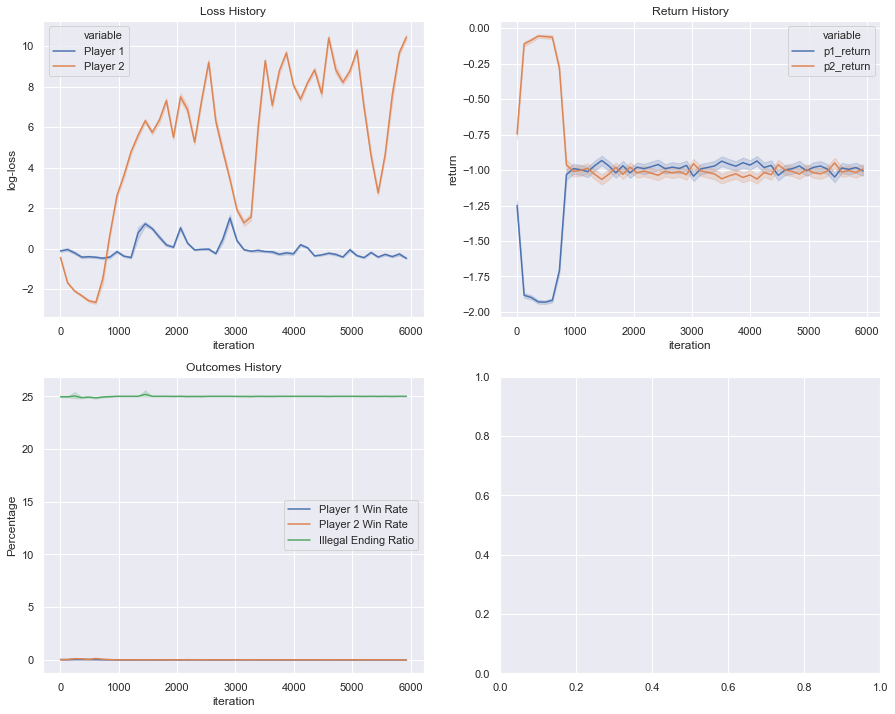

In [ ]:
try:
    plot_history()
    clear_output(wait=True)
    while iteration < num_iterations:
        collect_training_data()
        train()
        iteration += 1
        if iteration % plot_interval == 0:
            plot_history()
            clear_output(wait=True)

except KeyboardInterrupt:
    clear_output(wait=True)
    print('Interrupting training, plotting history...')
    plot_history()
    clear_output(wait=True)

In [253]:
games_data = pd.DataFrame.from_records(games)
games_data.head()

,iteration,game,p1_return,p2_return,outcome,final_step
0,0,0,-1000.0,0.0,illegal,"((tf.Tensor(2, shape=(), dtype=int32)), (tf.Te..."
1,0,1,0.0,-1000.0,illegal,"((tf.Tensor(2, shape=(), dtype=int32)), (tf.Te..."
2,0,2,1.0,0.0,p1_win,"((tf.Tensor(2, shape=(), dtype=int32)), (tf.Te..."
3,0,3,-1000.0,0.0,illegal,"((tf.Tensor(2, shape=(), dtype=int32)), (tf.Te..."
4,0,4,-1000.0,0.0,illegal,"((tf.Tensor(2, shape=(), dtype=int32)), (tf.Te..."


In [254]:
loss_data = pd.DataFrame.from_records(loss_infos)
loss_data.head()

,iteration,p1_loss,p2_loss
0,0,10766328.0,2265665.75
1,0,10671850.0,2359345.50
2,0,10906064.0,2140547.00
3,0,10796404.0,2234231.50
4,0,10874322.0,2140421.75


In [353]:
games_data['p1_win'] = games_data.outcome == 'p1_win'
games_data['p2_win'] = games_data.outcome == 'p2_win'
games_data['illegal'] = games_data.outcome == 'illegal'
grouped_games_data = games_data.groupby('iteration')
grouped_games_data = grouped_games_data[['game', 'p1_win', 'p2_win', 'illegal']]
game_totals =  grouped_games_data.max()['game'] + 1
summed_games_data = grouped_games_data.sum()
summed_games_data['p1_win_rate'] = summed_games_data.p1_win / game_totals
summed_games_data['p2_win_rate'] = summed_games_data.p2_win / game_totals
summed_games_data['illegal_rate'] = summed_games_data.illegal / game_totals
summed_games_data['iteration'] = summed_games_data.index
summed_games_data.head()

,game,p1_win,p2_win,illegal,p1_win_rate,p2_win_rate,illegal_rate,iteration
iteration,,,,,,,,
0,45,1.0,0.0,9.0,0.1,0.0,0.9,0
1,45,0.0,0.0,10.0,0.0,0.0,1.0,1
2,45,0.0,0.0,10.0,0.0,0.0,1.0,2
3,45,0.0,0.0,10.0,0.0,0.0,1.0,3
4,45,0.0,0.0,10.0,0.0,0.0,1.0,4


In [370]:
player_1._replay_buffer.get_next(num_steps = 2, sample_batch_size=3)

(Trajectory(step_type=<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[0, 1],
        [0, 0],
        [1, 1]])>, observation=<tf.Tensor: shape=(3, 2, 3, 3), dtype=int32, numpy=
 array([[[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[1, 0, 0],
          [0, 2, 0],
          [0, 0, 0]]],
 
 
        [[[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 0, 0],
          [0, 0, 0],
          [0, 0, 0]]],
 
 
        [[[0, 2, 0],
          [0, 0, 0],
          [0, 0, 0]],
 
         [[0, 2, 0],
          [0, 0, 1],
          [2, 0, 0]]]])>, action=<tf.Tensor: shape=(3, 2, 1), dtype=int32, numpy=
 array([[[0],
         [6]],
 
        [[5],
         [5]],
 
        [[5],
         [5]]])>, policy_info=(), next_step_type=<tf.Tensor: shape=(3, 2), dtype=int32, numpy=
 array([[1, 1],
        [1, 1],
        [1, 2]])>, reward=<tf.Tensor: shape=(3, 2), dtype=float32, numpy=
 array([[    0.,     0.],
        [    0.,     0.],
        [    0., -1000.]], d

In [597]:
ts = tf_ttt_env.reset()
player_1.reset()
player_2.reset()
print_tic_tac_toe(ts.observation.numpy())

if bool(random.randint(0, 1)):
    players = cycle([player_1, player_2])
else:
    players = cycle([player_2, player_1])
    
while not ts.is_last():
    player = next(players)
    player.act()
    ts = tf_ttt_env.current_time_step()
    print_tic_tac_toe(ts.observation.numpy())


      |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    

    O |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    

    O |   |  
    - + - + -
      |   |  
    - + - + -
      |   |  
    


In [403]:
ts = tf_ttt_env.reset()
out, state = player_1._q_network(ts.observation, step_type=ts.step_type)
out, tf.argmax(out, axis=-1)

(<tf.Tensor: shape=(1, 9), dtype=float32, numpy=
 array([[-6656374.5, -6647018. , -6655758. , -6662560.5, -6660408. ,
         -6648186.5, -6658006.5, -6658451. , -6650753.5]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=int64, numpy=array([1], dtype=int64)>)

In [400]:
player_1.policy.action(
    ts, 
    policy_state=player_1.policy.get_initial_state(batch_size=tf_ttt_env.batch_size))

PolicyStep(action=<tf.Tensor: shape=(1, 1), dtype=int32, numpy=array([[1]])>, state=[<tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[-0.7615942,  0.7615942, -0.7615942,  0.7615942,  0.7615942,
         0.7615942, -0.7615942,  0.7615942,  0.7615942, -0.7615942,
         0.7615942,  0.7615942,  0.7615942,  0.7615942,  0.7615942,
        -0.7615942,  0.7615942, -0.7615942, -0.7615942,  0.7615942,
         0.7615942,  0.7615942,  0.7615942, -0.7615942, -0.7615942,
        -0.7615942,  0.7615942,  0.7615942, -0.7615942,  0.7615942,
         0.7615942, -0.7615942, -0.7615942,  0.7615942,  0.7615942,
        -0.7615942,  0.7615942,  0.7615942,  0.7615942,  0.7615942]],
      dtype=float32)>, <tf.Tensor: shape=(1, 40), dtype=float32, numpy=
array([[-1.,  1., -1.,  1.,  1.,  1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
         1.,  1., -1.,  1., -1., -1.,  1.,  1.,  1.,  1., -1., -1., -1.,
         1.,  1., -1.,  1.,  1., -1., -1.,  1.,  1., -1.,  1.,  1.,  1.,
         1.]], dtype=float32)